In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score,precision_recall_fscore_support, roc_auc_score,average_precision_score,confusion_matrix,
                             RocCurveDisplay,PrecisionRecallDisplay)
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


In [2]:
DATA_PATH='creditcard.csv'
TARGET='Class'
RANDOM_STATE=42


In [3]:
df=pd.read_csv(DATA_PATH)
print("Shape:",df.shape)
print("Columns:",df.columns.tolist())
print("Missing % (top 10):\n",df.isna().mean().sort_values(ascending=False).head(10))
print("Describe:",df.describe(include='all').T.head(15))


Shape: (116942, 31)
Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Missing % (top 10):
 V13    0.000009
V12    0.000009
V11    0.000009
V10    0.000009
V9     0.000009
V8     0.000009
V7     0.000009
V14    0.000009
V21    0.000009
V20    0.000009
dtype: float64
Describe:          count          mean           std        min           25%  \
Time  116942.0  46555.919858  18692.683683   0.000000  35373.000000   
V1    116942.0     -0.254372      1.837763 -56.407510     -1.021560   
V2    116942.0     -0.011079      1.633274 -72.715728     -0.586654   
V3    116942.0      0.679823      1.296662 -33.680984      0.174900   
V4    116942.0      0.155177      1.335851  -5.172595     -0.705556   
V5    116942.0     -0.283503      1.333416 -42.147898     -0.904684   
V6    116942.0      0.091362      1.293633 -26.160506

In [4]:
fraud_rate=df[TARGET].mean()
print(f"Fraud prevalence: {fraud_rate:.4%}")


Fraud prevalence: 0.2087%


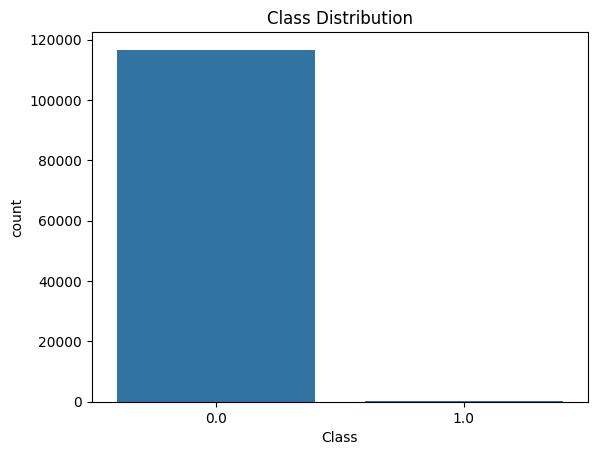

In [5]:
sns.countplot(x=TARGET,data=df)
plt.title('Class Distribution')
plt.show()

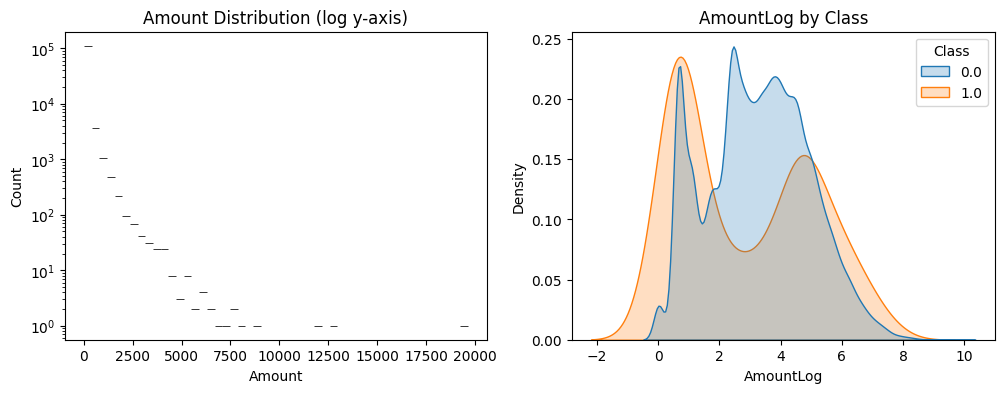

In [6]:
if "Amount" in df.columns:
  fig,ax=plt.subplots(1,2,figsize=(12,4))
  sns.histplot(df["Amount"],bins=50,ax=ax[0],log_scale=(False,True))
  ax[0].set_title("Amount Distribution (log y-axis)")
  df["AmountLog"]=np.log1p(df["Amount"])
  sns.kdeplot(data=df,x="AmountLog",hue=TARGET,common_norm=False,fill=True,ax=ax[1])
  ax[1].set_title("AmountLog by Class")
  plt.show()

In [7]:
df=df.drop_duplicates()
num_cols=df.select_dtypes(include=np.number).columns.tolist()
df[num_cols]=df[num_cols].fillna(df[num_cols].median())

In [9]:
if "Amount" in df.columns and "AmountLog" not in df.columns:
  df["AmountLog"]=np.log1p(df["Amount"])


In [10]:
if "Time" in df.columns:
  hour=(df["Time"] % (24*3600)) /3600.0
  df["Time_sin"]=np.sin(2*np.pi*hour/24)
  df["Time_cos"]=np.cos(2*np.pi*hour/24)


In [11]:
X=df.drop(columns=[TARGET])
y=df[TARGET].astype(int)

In [12]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=RANDOM_STATE,stratify=y)
num_features=X.columns.tolist()

In [13]:
scaler=StandardScaler()

In [14]:
majority_class=y_train.mode()[0]
y_pred_majority=np.full_like(y_test, fill_value=majority_class)
baseline_accuracy=(y_test==y_pred_majority).mean()
baseline_pr_auc=y_test.mean()
print(f"Baseline (majority class) Accuracy: {baseline_accuracy:.4f}")
print(f"Baseline PR AUC (prevalence): {baseline_pr_auc:.4f}")


Baseline (majority class) Accuracy: 0.9979
Baseline PR AUC (prevalence): 0.0021


In [16]:
models = {
    'Logistic Regression': Pipeline([('scale',scaler),('clf',LogisticRegression(max_iter=2000,class_weight='balanced'))]),
    'KNN': Pipeline([('scale',scaler),('clf',KNeighborsClassifier())]),
    'Decision Tree': Pipeline([('scale',scaler),('clf',DecisionTreeClassifier(random_state=RANDOM_STATE,class_weight='balanced'))]),
    'SVM': Pipeline([('scale',scaler),('clf',SVC(kernel='rbf',probability=True,class_weight='balanced'))])
}

In [18]:
def evaluate(name,model, X_train, y_train, X_test, y_test):
  t0=time.time()
  model.fit(X_train, y_train)
  fit_time=time.time()-t0
  y_tr_pred=model.predict(X_train)
  y_te_pred=model.predict(X_test)



In [23]:
def evaluate(name,model, X_train, y_train, X_test, y_test):
  t0=time.time()
  model.fit(X_train, y_train)
  fit_time=time.time()-t0
  y_tr_pred=model.predict(X_train)
  y_te_pred=model.predict(X_test)

  if hasattr(model, 'predict_proba'):
    y_scores=model.predict_proba(X_test)[:,1]
  else:
    last=model.named_steps.get('clf',model)
    if hasattr(last, 'predict_proba'):
      y_scores=last.predict_proba(model.named_steps['scale'].transform(X_test))[:,1]
    elif hasattr(last, 'decision_function'):
      y_scores=last.decision_function(model.named_steps['scale'].transform(X_test))
    else:
      y_scores=y_te_pred

  train_acc=accuracy_score(y_train, y_tr_pred)
  test_acc=accuracy_score(y_test, y_te_pred)
  prec,rec,f1,_=precision_recall_fscore_support(y_test, y_te_pred, average='binary')
  roc=roc_auc_score(y_test, y_scores) # Calculate ROC-AUC
  pr_auc=average_precision_score(y_test, y_scores) # Calculate PR AUC

  return {
      'Model': name,
      'Train Accuracy': round(train_acc,4),
      'Test Accuracy': round(test_acc,4),
      'Precision': round(prec,4),
      'Recall': round(rec,4),
      'F1 Score': round(f1,4),
      'ROC-AUC':round(roc,4),
      'PR-AUC': round(pr_auc,4),
      'Fit Time': round(fit_time,4)
  }, model

In [24]:
results=[]
fitted_models={}
for name, model in models.items():
  res,fitted=evaluate(name,model, X_train, y_train, X_test, y_test)
  results.append(res)
  fitted_models[name]=fitted
results_df=pd.DataFrame(results).sort_values(by=["PR-AUC","Recall"],ascending=False).reset_index(drop=True)
print(results_df)

                 Model  Train Accuracy  Test Accuracy  Precision  Recall  \
0                  KNN          0.9996         0.9993     0.9211  0.7292   
1                  SVM          0.9990         0.9986     0.6471  0.6875   
2  Logistic Regression          0.9803         0.9791     0.0787  0.8542   
3        Decision Tree          1.0000         0.9987     0.6977  0.6250   

   F1 Score  ROC-AUC  PR-AUC  Fit Time  
0    0.8140   0.9061  0.7823    0.0888  
1    0.6667   0.9656  0.7382  185.8210  
2    0.1441   0.9472  0.4870    1.1042  
3    0.6593   0.8122  0.4368    3.7884  


In [25]:
best_name=results_df.loc[0,'Model']
best_model=fitted_models[best_name]
print("Best model by PR_AUC:",best_name)

Best model by PR_AUC: KNN


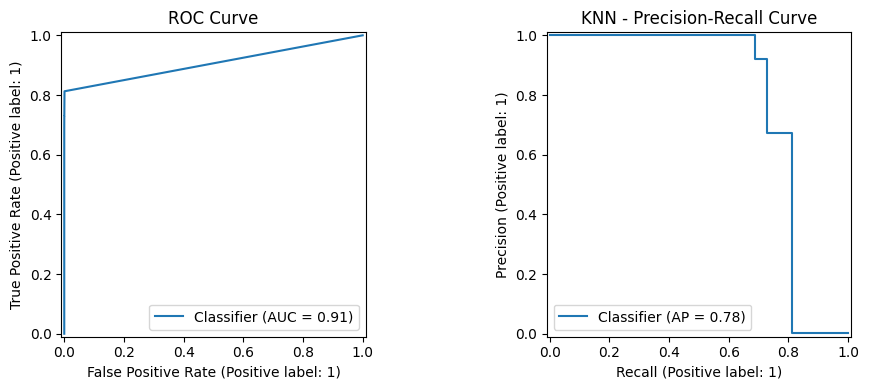

In [28]:
if hasattr(best_model, 'predict_proba'):
  y_score=best_model.predict_proba(X_test)[:,1]
else:
  y_score=best_model.decision_function(X_test)
fig,axes=plt.subplots(1,2,figsize=(10,4))
RocCurveDisplay.from_predictions(y_test, y_score, ax=axes[0])
axes[0].set_title("ROC Curve")
PrecisionRecallDisplay.from_predictions(y_test, y_score,ax=axes[1])
axes[1].set_title(f"{best_name} - Precision-Recall Curve")
plt.tight_layout()
plt.show()

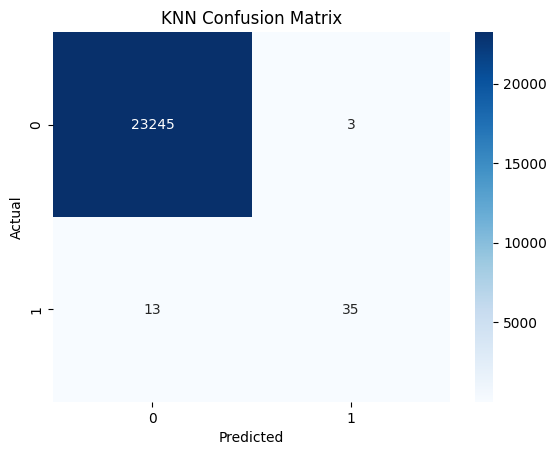

In [29]:
y_pred=best_model.predict(X_test)
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"{best_name} Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [33]:
from sklearn.metrics import precision_recall_curve
# Example: Choose threshold to achieve at least 80% recall
if hasattr(best_model, 'predict_proba'):
  y_score=best_model.predict_proba(X_test)[:,1]
else:
  y_score=best_model.decision_function(X_test)
prec,rec,thr=precision_recall_curve(y_test, y_score)
target_recall=0.8
idx=np.where(rec>=target_recall)[0]
if len(idx)>0:
  t_star=thr[idx[0]] if idx[0]<len(thr) else 0.5
  print(f"Threshold for > {target_recall*100:.0f}% recall:",round(float(t_star),4))
  y_opt=(y_score>=t_star).astype(int)
  p_opt,r_opt,f1_opt,_=precision_recall_fscore_support(y_test, y_opt, average='binary',zero_division=0)
  print({"Precision": round(p_opt,4),"Recall": round(r_opt,4),"F1": round(f1_opt,4)})

Threshold for > 80% recall: 0.0
{'Precision': 0.0021, 'Recall': 1.0, 'F1': 0.0041}
